Format — All patient medical images are saved in the __DICOM__ file format. This format has PHI (protected health information) about the patient such as — name, sex, age in addition to other image related data such as equipment used to capture the image and some context to the medical treatment. Medical Imaging Equipments create DICOM files. 

In [2]:
import pydicom # dicom handler package
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.ndimage
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pickle

In [3]:
# Populating file list data
input_root = 'D:\TestData_LungCancer\CPTAC-LUAD'

def load_scan(path):
    file_list = []
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():
                file_list.append(os.path.join(dirName,filename))
    return file_list

In [30]:
%%time
#Perform scan
files = load_scan(input_root)
small_list = files[0:100]
working_files = files # for now this will be used as a swtich between big/small data set

Wall time: 75.1 ms


In [28]:
%%time

def extract_pixel_spacing(files, outputFilename = 'PixelSpacing_ForTestData.csv'):
    size_data = {'x':[],'y':[]}
    for filenameDCM in files:
        # read the file
        ds = pydicom.read_file(filenameDCM, stop_before_pixels=True)
        try:
            size_data['x'].append(ds.ImagerPixelSpacing[0])
            size_data['y'].append(ds.ImagerPixelSpacing[1])
        except Exception as e:
            size_data['x'].append(ds.PixelSpacing[0])
            size_data['y'].append(ds.PixelSpacing[1])
    pd.DataFrame(size_data).to_csv(outputFilename)
    
#extract_pixel_spacing(small_list, 'smallList_Spacing.csv')

def resize_dicom_image(image, size_x = 6000, size_y=6000):
    result =cv2.resize(image, dsize=(size_x, size_y), interpolation= cv2.INTER_CUBIC)
    return result


def create_unified_sized_image(dicom_file):
    ConstPixelDims = (int(dicom_file.Rows), int(dicom_file.Columns))
    ConstPixelSpacing = (float(RefDs.ImagerPixelSpacing[0]),float(RefDs.ImagerPixelSpacing[1]))
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])

    
def create_teaching_array(files, size = 576):
    #Taking the first image as a reference base
    reference = pydicom.read_file(files[0])
    ReferenceConstPixelDims = (int(reference.Rows), int(reference.Columns), len(files))
    ReferenceConstPixelDims = (size, size, len(files))
    ArrayImg = np.zeros(ReferenceConstPixelDims, dtype = reference.pixel_array.dtype)
    
    for index,fileName in enumerate(files):
        ds = pydicom.read_file(fileName)
        #unified_image = create_unified_sized_image(ds)
        resized = resize_dicom_image(ds.pixel_array, size_x = size, size_y = size)
        #resize_dicom_image(unified_image, size_x=ReferenceConstPixelDims[0], size_y=ReferenceConstPixelDims[1])
        ArrayImg[:,:,index] = resized
    return ArrayImg

Wall time: 0 ns


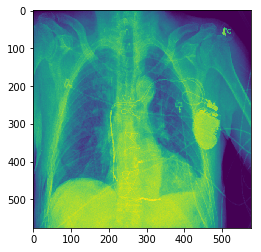

In [16]:
res = resize_dicom_image(pydicom.read_file(small_list[0]).pixel_array, size_x = 576, size_y = 576)
plt.imshow(res)

In [40]:
%%time
teach_array = create_teaching_array(small_list)
print("Teaching array is ready!\nImage size: {0}x{0}, with {1} images".format(len(teach_array[0]), len(teach_array[2])))
pickle.dump(teach_array, open("teach_array.p", "wb"))

Teaching array is ready!
Image size: 576x576, with 576 images
Wall time: 1.6 s


In [68]:
def preproceess_images(filePath, max_num):
    files = load_scan(filePath)
    files = files[0:max_num]
    teach_array = create_teaching_array(files, size = 1024)
    print("Teaching array is ready!\nImage size: {0}x{0}, with {1} images".format(1024, max_num))
    pickle.dump(teach_array, open("teach_array.p", "wb"))
    return teach_array

In [69]:
%%time
teach_array = preproceess_images(input_root,150)

Teaching array is ready!
Image size: 1024x1024, with 150 images
Wall time: 7.75 s


In [71]:
teach_array.shape

(1024, 1024, 150)

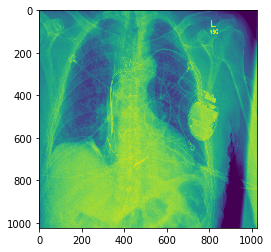

In [75]:
plt.imshow(teach_array[:,:,2])

In [66]:
8300/50

166.0

In [67]:
1660*100

166000